<a href="https://colab.research.google.com/github/T-Yamaguch/WGAN/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, \
MaxPooling2D, Activation, ReLU, LeakyReLU, UpSampling2D, BatchNormalization, \
Dropout, Dense, Flatten, Add, LayerNormalization, GaussianNoise, Reshape, Lambda
from keras.regularizers import l2

class conv_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(conv_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()
    self.up = UpSampling2D((2,2))
    self.noise = GaussianNoise(0.2)

  def call(self, x):
    x = self.conv(x)
    # x = self.norm(x)
    x = self.act(x)
    x = self.up(x)
    x = self.noise(x)
    return x

class res_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(res_block, self).__init__()
    self.conv1 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.conv2 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm1 = BatchNormalization(trainable=True)
    self.norm2 = BatchNormalization(trainable=True)
    self.act1 = ReLU()
    self.act2 = ReLU()
    self.add = Add()

  def call(self, x):
    y = self.conv1(x)
    y = self.norm1(y)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.norm2(y)
    y = self.act2(y)
    x = self.add([x, y])
    return x

class disc_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(disc_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()
    self.pooling = MaxPooling2D((2,2), strides=(2,2))
    self.drop = Dropout(0.3)

  def call(self, x):
    x = self.conv(x)
    # x = self.norm(x) dにnorm入れないほうがいいという噂
    x = self.act(x)
    x = self.pooling(x)
    x = self.drop(x)
    return x

class dense_block(Model):
  def __init__(self, filter_num, kernel_regularizer= l2(0.001)):
    super(dense_block, self).__init__()
    self.dense = Dense(filter_num, kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()

  def call(self, x):
    x = self.dense(x)
    x = self.norm(x)
    x = self.act(x)
    return x




In [3]:
class Generator():
  def __init__(self):
    self.channel_num = 64
    self.layer_num = 5
    self.res_num = 0
    self.latent_num = 4*4*self.channel_num
    self.inputs = Input(shape=(self.latent_num)) 
    self.kernel_size = (5, 5)
    self.name = 'generator'
    self.kernel_regularizer= None
      
  def model(self):
    x = self.inputs

    # final_size = 4*4*self.channel_num
    # data_size = self.latent_num

    # while data_size*4 < final_size:
    #   data_size *= 4
    #   x = dense_block(data_size, kernel_regularizer= self.kernel_regularizer)(x)

    # x = dense_block(final_size, kernel_regularizer= self.kernel_regularizer)(x)
    x = Reshape((4, 4, self.channel_num))(x)

    filter_num = self.channel_num
    
    for n in range(self.layer_num):
      for m in range(self.res_num):
        x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      # filter_num /= 2
      x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    for m in range(self.res_num):
      x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = Conv2D(filter_num, self.kernel_size, padding = 'same', kernel_regularizer= self.kernel_regularizer)(x)
    # x = BatchNormalization(trainable=True)(x)
    x = ReLU()(x)

    x = Conv2D(3, (1,1), padding='same')(x)
    x = Activation('sigmoid')(x)
    outputs = x
    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

g = Generator()
g.model().summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv_block (conv_block)      (None, 8, 8, 64)          102464    
_________________________________________________________________
conv_block_1 (conv_block)    (None, 16, 16, 64)        102464    
_________________________________________________________________
conv_block_2 (conv_block)    (None, 32, 32, 64)        102464    
_________________________________________________________________
conv_block_3 (conv_block)    (None, 64, 64, 64)        102464    
_________________________________________________________________
conv_block_4 (conv_block)    (None, 128, 128, 64)      10

In [4]:
class Discriminator():
  def __init__(self):
    self.channel_num = 8
    self.layer_num = 5
    self.latent_num = 8
    self.input_shape = (128, 128, 3)
    self.patch_shape = (32, 32, 3)
    self.inputs = Input(shape=self.input_shape)
    self.patch_inputs = Input(shape=self.patch_shape)
    self.kernel_size = (3, 3)
    self.name = 'discriminator'
    self.kernel_regularizer= None

  def patch_model(self):
    x = self.patch_inputs

    filter_num = self.channel_num
    for n in range(self.layer_num):
      x = disc_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num *= 2

    x = Flatten()(x)
    x = dense_block(32, kernel_regularizer= self.kernel_regularizer)(x)

    # x = Dense(self.latent_num)(x)
    # x = Activation('sigmoid')(x)

    outputs = x

    return Model(inputs = self.patch_inputs, outputs = outputs, name = 'patch_model')

  def model(self):
    x = self.inputs

    # h, w = self.input_shape[:-1]
    # ph, pw = self.patch_shape[:-1]
    # list_row_idx = [(i*ph, (i+1)*ph) for i in range(h//ph)]
    # list_col_idx = [(i*pw, (i+1)*pw) for i in range(w//pw)]

    # list_patch = []
    # for row_idx in list_row_idx:
    #     for col_idx in list_col_idx:
    #         x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(x)
    #         list_patch.append(x_patch)

    # patch_num = (h//ph)*(w//pw)

    # patch_model = self.patch_model()
    # x = [patch_model(list_patch[i]) for i in range(patch_num)]

    # x = Concatenate(axis=-1)(x)


    filter_num = self.channel_num
    for n in range(self.layer_num):
      x = disc_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num *= 2
    x = Conv2D(filter_num, self.kernel_size, padding = 'same', kernel_regularizer= self.kernel_regularizer)(x)
    # x = BatchNormalization(trainable=True)(x)
    x = ReLU()(x)
    # x = dense_block(512, kernel_regularizer= self.kernel_regularizer)(x)

    # x1 = Dense(1)(x)
    # x1 = Activation('tanh')(x1)

    # x2 = Dense(self.latent_num)(x)
    # x2 = Activation('sigmoid')(x2)

    # outputs = [x1, x2]

    x = Flatten()(x)
    outputs = Dense(1)(x)

    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

d = Discriminator()
# d.patch_model().summary()
d.model().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
disc_block (disc_block)      (None, 64, 64, 8)         224       
_________________________________________________________________
disc_block_1 (disc_block)    (None, 32, 32, 16)        1168      
_________________________________________________________________
disc_block_2 (disc_block)    (None, 16, 16, 32)        4640      
_________________________________________________________________
disc_block_3 (disc_block)    (None, 8, 8, 64)          18496     
_________________________________________________________________
disc_block_4 (disc_block)    (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 256)       


epochs 1
d: steps64
g_train

epochs 2
d: steps64
g_train

epochs 3
d: steps64
g_train

epochs 4
d: steps64
g_train

epochs 5
d: steps64
g_train

epochs 6
d: steps64
g_train

epochs 7
d: steps64
g_train

epochs 8
d: steps64
g_train

epochs 9
d: steps64
g_train

epochs 10
d: steps64
g_train


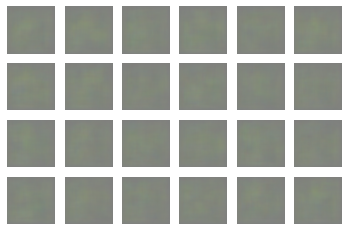


epochs 11
d: steps64
g_train

epochs 12
d: steps64
g_train

epochs 13
d: steps64
g_train

epochs 14
d: steps64
g_train

epochs 15
d: steps64
g_train

epochs 16
d: steps64
g_train

epochs 17
d: steps64
g_train

epochs 18
d: steps64
g_train

epochs 19
d: steps64
g_train

epochs 20
d: steps64
g_train


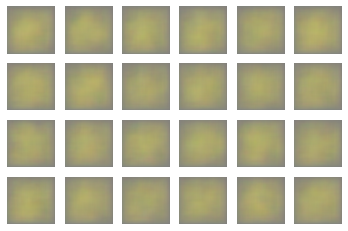


epochs 21
d: steps64
g_train

epochs 22
d: steps64
g_train

epochs 23
d: steps64
g_train

epochs 24
d: steps64
g_train

epochs 25
d: steps64
g_train

epochs 26
d: steps64
g_train

epochs 27
d: steps64
g_train

epochs 28
d: steps64
g_train

epochs 29
d: steps64
g_train

epochs 30
d: steps64
g_train


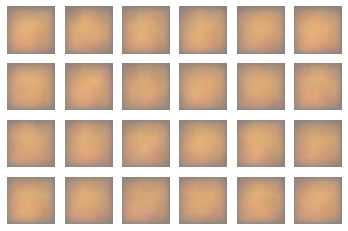


epochs 31
d: steps64
g_train

epochs 32
d: steps64
g_train

epochs 33
d: steps64
g_train

epochs 34
d: steps64
g_train

epochs 35
d: steps64
g_train

epochs 36
d: steps64
g_train

epochs 37
d: steps64
g_train

epochs 38
d: steps64
g_train

epochs 39
d: steps64
g_train

epochs 40
d: steps64
g_train


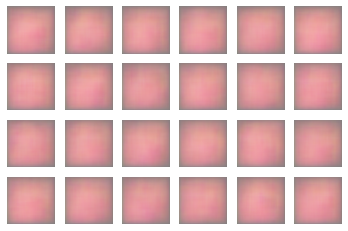


epochs 41
d: steps64
g_train

epochs 42
d: steps64
g_train

epochs 43
d: steps64
g_train

epochs 44
d: steps64
g_train

epochs 45
d: steps64
g_train

epochs 46
d: steps64
g_train

epochs 47
d: steps64
g_train

epochs 48
d: steps64
g_train

epochs 49
d: steps64
g_train

epochs 50
d: steps64
g_train


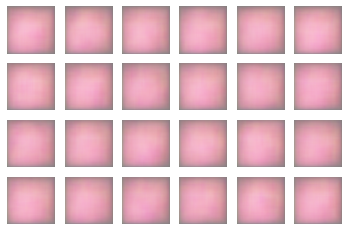


epochs 51
d: steps64
g_train

epochs 52
d: steps64
g_train

epochs 53
d: steps64
g_train

epochs 54
d: steps64
g_train

epochs 55
d: steps64
g_train

epochs 56
d: steps64
g_train

epochs 57
d: steps64
g_train

epochs 58
d: steps64
g_train

epochs 59
d: steps64
g_train

epochs 60
d: steps64
g_train


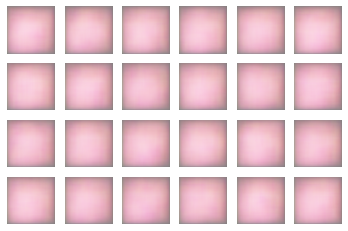


epochs 61
d: steps64
g_train

epochs 62
d: steps64
g_train

epochs 63
d: steps64
g_train

epochs 64
d: steps64
g_train

epochs 65
d: steps64
g_train

epochs 66
d: steps64
g_train

epochs 67
d: steps64
g_train

epochs 68
d: steps64
g_train

epochs 69
d: steps64
g_train

epochs 70
d: steps64
g_train


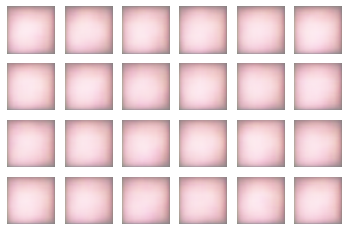


epochs 71
d: steps64
g_train

epochs 72
d: steps64
g_train

epochs 73
d: steps64
g_train

epochs 74
d: steps64
g_train

epochs 75
d: steps64
g_train

epochs 76
d: steps64
g_train

epochs 77
d: steps64
g_train

epochs 78
d: steps64
g_train

epochs 79
d: steps64
g_train

epochs 80
d: steps64
g_train


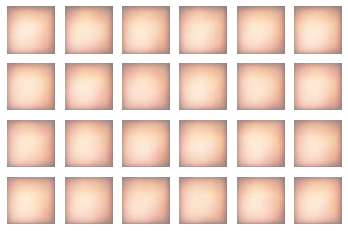


epochs 81
d: steps64
g_train

epochs 82
d: steps64
g_train

epochs 83
d: steps64
g_train

epochs 84
d: steps64
g_train

epochs 85
d: steps64
g_train

epochs 86
d: steps64
g_train

epochs 87
d: steps64
g_train

epochs 88
d: steps64
g_train

epochs 89
d: steps64
g_train

epochs 90
d: steps64
g_train


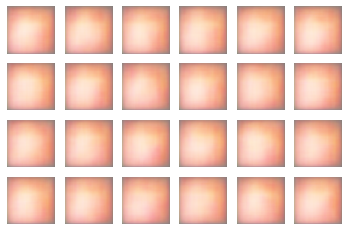


epochs 91
d: steps64
g_train

epochs 92
d: steps64
g_train

epochs 93
d: steps64
g_train

epochs 94
d: steps64
g_train

epochs 95
d: steps64
g_train

epochs 96
d: steps64
g_train

epochs 97
d: steps64
g_train

epochs 98
d: steps64
g_train

epochs 99
d: steps64
g_train

epochs 100
d: steps64
g_train


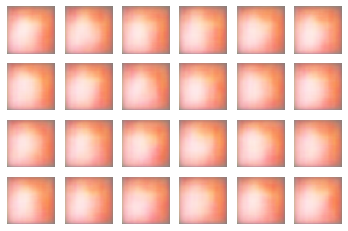


Saving checkpoint at epoch100



epochs 101
d: steps64
g_train

epochs 102
d: steps64
g_train

epochs 103
d: steps64
g_train

epochs 104
d: steps64
g_train

epochs 105
d: steps64
g_train

epochs 106
d: steps64
g_train

epochs 107
d: steps64
g_train

epochs 108
d: steps64
g_train

epochs 109
d: steps64
g_train

epochs 110
d: steps64
g_train


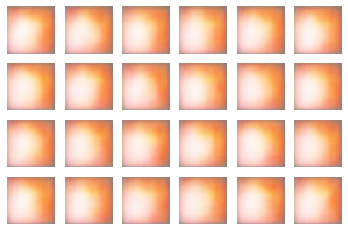


epochs 111
d: steps64
g_train

epochs 112
d: steps64
g_train

epochs 113
d: steps64
g_train

epochs 114
d: steps64
g_train

epochs 115
d: steps64
g_train

epochs 116
d: steps64
g_train

epochs 117
d: steps64
g_train

epochs 118
d: steps64
g_train

epochs 119
d: steps64
g_train

epochs 120
d: steps64
g_train


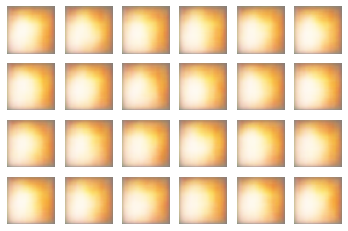


epochs 121
d: steps64
g_train

epochs 122
d: steps64
g_train

epochs 123
d: steps64
g_train

epochs 124
d: steps64
g_train

epochs 125
d: steps64
g_train

epochs 126
d: steps64
g_train

epochs 127
d: steps64
g_train

epochs 128
d: steps64
g_train

epochs 129
d: steps64
g_train

epochs 130
d: steps64
g_train


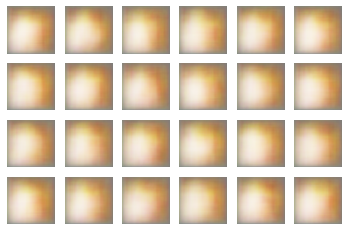


epochs 131
d: steps64
g_train

epochs 132
d: steps64
g_train

epochs 133
d: steps64
g_train

epochs 134
d: steps64
g_train

epochs 135
d: steps64
g_train

epochs 136
d: steps64
g_train

epochs 137
d: steps64
g_train

epochs 138
d: steps64
g_train

epochs 139
d: steps64
g_train

epochs 140
d: steps64
g_train


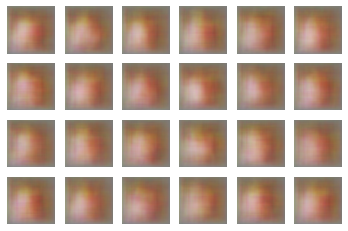


epochs 141
d: steps64
g_train

epochs 142
d: steps64
g_train

epochs 143
d: steps64
g_train

epochs 144
d: steps64
g_train

epochs 145
d: steps64
g_train

epochs 146
d: steps64
g_train

epochs 147
d: steps64
g_train

epochs 148
d: steps64
g_train

epochs 149
d: steps64
g_train

epochs 150
d: steps64
g_train


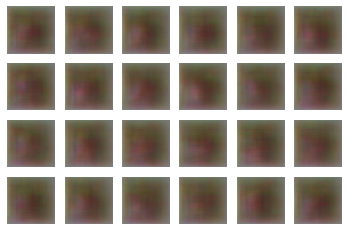


epochs 151
d: steps64
g_train

epochs 152
d: steps64
g_train

epochs 153
d: steps64
g_train

epochs 154
d: steps64
g_train

epochs 155
d: steps64
g_train

epochs 156
d: steps64
g_train

epochs 157
d: steps64
g_train

epochs 158
d: steps64
g_train

epochs 159
d: steps64
g_train

epochs 160
d: steps64
g_train


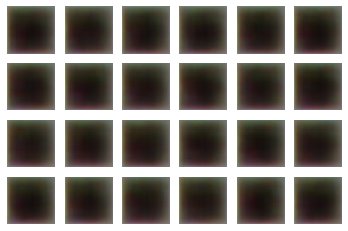


epochs 161
d: steps64
g_train

epochs 162
d: steps64
g_train

epochs 163
d: steps64
g_train

epochs 164
d: steps64
g_train

epochs 165
d: steps64
g_train

epochs 166
d: steps64
g_train

epochs 167
d: steps64
g_train

epochs 168
d: steps64
g_train

epochs 169
d: steps64
g_train

epochs 170
d: steps64
g_train


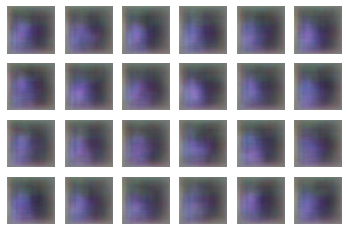


epochs 171
d: steps64
g_train

epochs 172
d: steps64
g_train

epochs 173
d: steps64
g_train

epochs 174
d: steps64
g_train

epochs 175
d: steps64
g_train

epochs 176
d: steps64
g_train

epochs 177
d: steps64
g_train

epochs 178
d: steps64
g_train

epochs 179
d: steps64
g_train

epochs 180
d: steps64
g_train


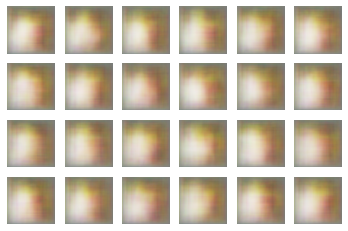


epochs 181
d: steps64
g_train

epochs 182
d: steps64
g_train

epochs 183
d: steps64
g_train

epochs 184
d: steps64
g_train

epochs 185
d: steps64
g_train

epochs 186
d: steps64
g_train

epochs 187
d: steps64
g_train

epochs 188
d: steps64
g_train

epochs 189
d: steps64
g_train

epochs 190
d: steps64
g_train


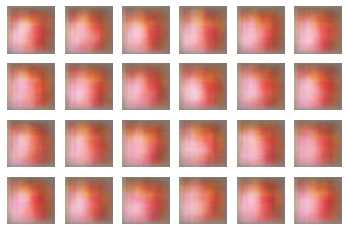


epochs 191
d: steps64
g_train

epochs 192
d: steps64
g_train

epochs 193
d: steps64
g_train

epochs 194
d: steps64
g_train

epochs 195
d: steps64
g_train

epochs 196
d: steps64
g_train

epochs 197
d: steps64
g_train

epochs 198
d: steps64
g_train

epochs 199
d: steps64
g_train

epochs 200
d: steps64
g_train


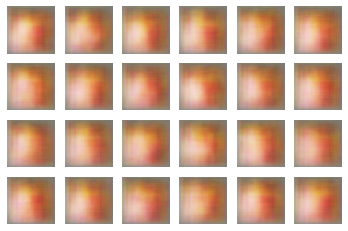


Saving checkpoint at epoch200



epochs 201
d: steps64
g_train

epochs 202
d: steps64
g_train

epochs 203
d: steps64
g_train

epochs 204
d: steps64
g_train

epochs 205
d: steps64
g_train

epochs 206
d: steps64
g_train

epochs 207
d: steps64
g_train

epochs 208
d: steps64
g_train

epochs 209
d: steps64
g_train

epochs 210
d: steps64
g_train


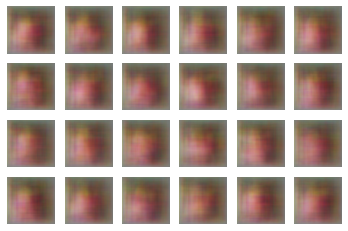


epochs 211
d: steps64
g_train

epochs 212
d: steps64
g_train

epochs 213
d: steps64
g_train

epochs 214
d: steps64
g_train

epochs 215
d: steps64
g_train

epochs 216
d: steps64
g_train

epochs 217
d: steps64
g_train

epochs 218
d: steps64
g_train

epochs 219
d: steps64
g_train

epochs 220
d: steps64
g_train


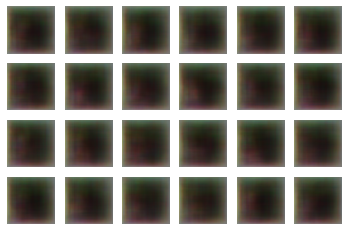


epochs 221
d: steps64
g_train

epochs 222
d: steps64
g_train

epochs 223
d: steps64
g_train

epochs 224
d: steps64
g_train

epochs 225
d: steps64
g_train

epochs 226
d: steps64
g_train

epochs 227
d: steps64
g_train

epochs 228
d: steps64
g_train

epochs 229
d: steps64
g_train

epochs 230
d: steps64
g_train


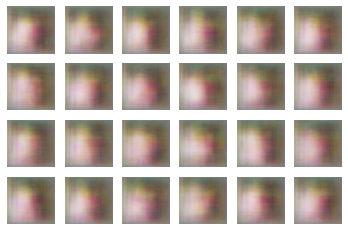


epochs 231
d: steps64
g_train

epochs 232
d: steps64
g_train

epochs 233
d: steps64
g_train

epochs 234
d: steps64
g_train

epochs 235
d: steps64
g_train

epochs 236
d: steps64
g_train

epochs 237
d: steps64
g_train

epochs 238
d: steps64
g_train

epochs 239
d: steps64
g_train

epochs 240
d: steps64
g_train


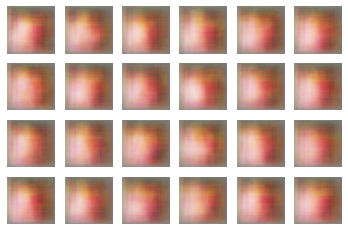


epochs 241
d: steps64
g_train

epochs 242
d: steps64
g_train

epochs 243
d: steps64
g_train

epochs 244
d: steps64
g_train

epochs 245
d: steps64
g_train

epochs 246
d: steps64
g_train

epochs 247
d: steps64
g_train

epochs 248
d: steps64
g_train

epochs 249
d: steps64
g_train

epochs 250
d: steps64
g_train


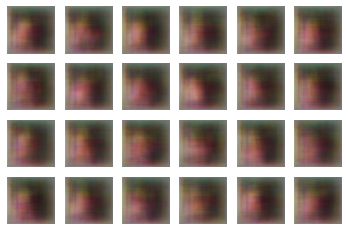


epochs 251
d: steps64
g_train

epochs 252
d: steps64
g_train

epochs 253
d: steps64
g_train

epochs 254
d: steps64
g_train

epochs 255
d: steps64
g_train

epochs 256
d: steps64
g_train

epochs 257
d: steps64
g_train

epochs 258
d: steps64
g_train

epochs 259
d: steps64
g_train

epochs 260
d: steps64
g_train


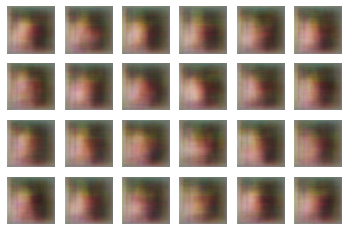


epochs 261
d: steps64
g_train

epochs 262
d: steps64
g_train

epochs 263
d: steps64
g_train

epochs 264
d: steps64
g_train

epochs 265
d: steps64
g_train

epochs 266
d: steps64
g_train

epochs 267
d: steps64
g_train

epochs 268
d: steps64
g_train

epochs 269
d: steps64
g_train

epochs 270
d: steps64
g_train


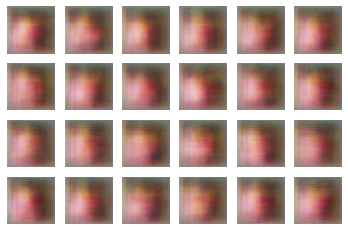


epochs 271
d: steps64
g_train

epochs 272
d: steps64
g_train

epochs 273
d: steps64
g_train

epochs 274
d: steps64
g_train

epochs 275
d: steps64
g_train

epochs 276
d: steps64
g_train

epochs 277
d: steps64
g_train

epochs 278
d: steps64
g_train

epochs 279
d: steps64
g_train

epochs 280
d: steps64
g_train


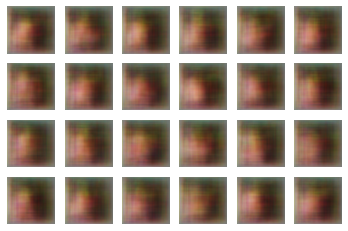


epochs 281
d: steps64
g_train

epochs 282
d: steps64
g_train

epochs 283
d: steps64
g_train

epochs 284
d: steps64
g_train

epochs 285
d: steps64
g_train

epochs 286
d: steps64
g_train

epochs 287
d: steps64
g_train

epochs 288
d: steps64
g_train

epochs 289
d: steps64
g_train

epochs 290
d: steps64
g_train


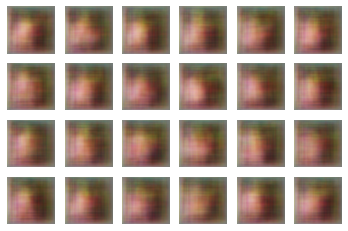


epochs 291
d: steps64
g_train

epochs 292
d: steps64
g_train

epochs 293
d: steps64
g_train

epochs 294
d: steps64
g_train

epochs 295
d: steps64
g_train

epochs 296
d: steps64
g_train

epochs 297
d: steps64
g_train

epochs 298
d: steps64
g_train

epochs 299
d: steps64
g_train

epochs 300
d: steps64
g_train


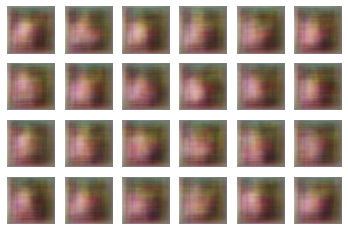


Saving checkpoint at epoch300



epochs 301
d: steps64
g_train

epochs 302
d: steps64
g_train

epochs 303
d: steps64
g_train

epochs 304
d: steps64
g_train

epochs 305
d: steps64
g_train

epochs 306
d: steps64
g_train

epochs 307
d: steps64
g_train

epochs 308
d: steps64
g_train

epochs 309
d: steps64
g_train

epochs 310
d: steps64
g_train


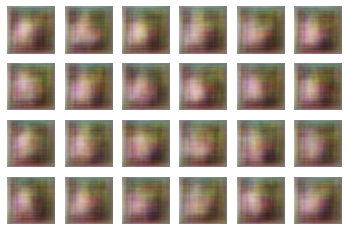


epochs 311
d: steps64
g_train

epochs 312
d: steps64
g_train

epochs 313
d: steps64
g_train

epochs 314
d: steps64
g_train

epochs 315
d: steps64
g_train

epochs 316
d: steps64
g_train

epochs 317
d: steps64
g_train

epochs 318
d: steps64
g_train

epochs 319
d: steps64
g_train

epochs 320
d: steps64
g_train


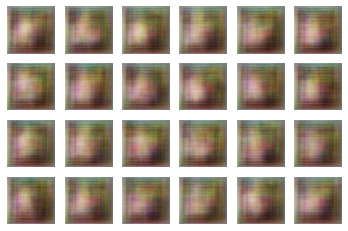


epochs 321
d: steps64
g_train

epochs 322
d: steps64
g_train

epochs 323
d: steps64
g_train

epochs 324
d: steps64
g_train

epochs 325
d: steps64
g_train

epochs 326
d: steps64
g_train

epochs 327
d: steps64
g_train

epochs 328
d: steps64
g_train

epochs 329
d: steps64
g_train

epochs 330
d: steps64
g_train


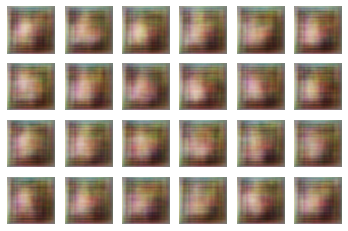


epochs 331
d: steps64
g_train

epochs 332
d: steps64
g_train

epochs 333
d: steps64
g_train

epochs 334
d: steps64
g_train

epochs 335
d: steps64
g_train

epochs 336
d: steps64
g_train

epochs 337
d: steps64
g_train

epochs 338
d: steps64
g_train

epochs 339
d: steps64
g_train

epochs 340
d: steps64
g_train


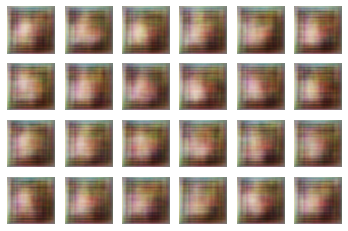


epochs 341
d: steps64
g_train

epochs 342
d: steps64
g_train

epochs 343
d: steps64
g_train

epochs 344
d: steps64
g_train

epochs 345
d: steps33

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy, MSE
import glob
import time
import random
import sys

class WGAN():
  def __init__(self, 
               img_size=128, 
               code_num = 2048,
               batch_size = 16, 
               train_epochs = 100, 
               train_steps = 8, 
               checkpoint_epochs = 25, 
               image_epochs = 1, 
               start_epoch = 1,
               optimizer = Adam(learning_rate = 1e-4)
               ):
    
    self.batch_size = batch_size
    self.train_epochs =  train_epochs
    self.train_steps = train_steps
    self.checkpoint_epochs = checkpoint_epochs
    self.image_epochs = image_epochs
    self.start_epoch = start_epoch
    self.code_num = code_num
    self.img_size = img_size
    
    self.gen_optimizer = optimizer
    self.disc_optimizer = optimizer

    g = Generator()
    self.gen = g.model()
    
    d = Discriminator()
    self.disc = d.model()

    checkpoint_dir = "drive/My Drive/WGAN/checkpoint"
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(gen_optimizer = self.gen_optimizer,
                                     disc_optimizer = self.disc_optimizer,
                                     gen = self.gen,
                                     disc = self.disc,
                                     )

    self.manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=2)

    train_image_path = 'drive/My Drive/samples/image'
    
    self.train_filenames = glob.glob(train_image_path + '/*.jpg') 

    checkpoint.restore(self.manager.latest_checkpoint)

    self.g_history = []
    self.d_history = []
    # self.endec_history = []  

  def preprocess_image(self, image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [self.img_size, self.img_size] )
    image = image/255  # normalize to [0,1] range
    return tf.cast(image, tf.float32)

  def load_and_preprocess_image(self, path):
    image = tf.io.read_file(path)
    return self.preprocess_image(image)

  def dataset(self, paths, batch_size):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    img_ds = path_ds.map(self.load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    img_ds = img_ds.batch(batch_size)
    return img_ds

  def image_preparation(self, filenames, batch_size, steps):
    img_batch = []
    while 1:
      random.shuffle(filenames)
      for path in filenames:
        img_batch.append(path)
        if len(img_batch) == steps*batch_size:
          imgs = self.dataset(img_batch, batch_size)
          img_batch = []
          yield imgs

  def discriminator_loss(self, original_outputs, generated_outputs):
    real_loss = binary_crossentropy(tf.ones_like(original_outputs), original_outputs)
    generated_loss = binary_crossentropy(tf.zeros_like(generated_outputs), generated_outputs)
    loss_d = tf.math.reduce_mean(real_loss + generated_loss)
    return loss_d

  def generator_loss(self, generated_outputs):
    loss_g = tf.math.reduce_mean(binary_crossentropy(tf.ones_like(generated_outputs), generated_outputs))
    return loss_g

  def mse_loss(self, true, pred):
    loss =  tf.math.reduce_mean(MSE(true, pred))
    return loss

  def wasserstein_loss(self, ori_outputs, gen_outputs):
    d_loss = -tf.reduce_mean(ori_outputs) + tf.reduce_mean(gen_outputs)
    g_loss = -tf.reduce_mean(gen_outputs)
    return d_loss, g_loss
  
  def gan_train(self, imgs, n):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_imgs = self.gen(noise, training=True)

      ori_outputs = self.disc(imgs, training=True)
      gen_outputs = self.disc(gen_imgs, training=True)

      # ori_outputs, ori_styles = self.disc(imgs, training=True)
      # gen_outputs, gen_styles = self.disc(gen_imgs, training=True)
      
      # gen_loss = self.generator_loss(gen_outputs)      
      # disc_loss = self.discriminator_loss(ori_outputs, gen_outputs)

      # re_gen_imgs = self.gen(ori_styles, training=True)

      # endec_loss = self.mse_loss(imgs, re_gen_imgs)
      # self.endec_history.append(endec_loss)
      
      disc_loss, gen_loss = self.wasserstein_loss(ori_outputs, gen_outputs)
      self.g_history.append(gen_loss)
      self.d_history.append(disc_loss)

      # endec_rate = 10*(0.98**n)
      # g_loss = gen_loss + endec_loss * endec_rate
      # d_loss = disc_loss + endec_loss * endec_rate

      g_loss = gen_loss
      d_loss = disc_loss


    gradients_of_gen = gen_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gradients_of_gen, self.gen.trainable_variables))

    gradients_of_disc = disc_tape.gradient(d_loss, self.disc.trainable_variables)    
    self.disc_optimizer.apply_gradients(zip(gradients_of_disc, self.disc.trainable_variables))

  def g_train(self, imgs, n):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as gen_tape:
      gen_imgs = self.gen(noise, training=True)

      ori_outputs = self.disc(imgs, training=False)
      gen_outputs = self.disc(gen_imgs, training=False)

      _, g_loss = self.wasserstein_loss(ori_outputs, gen_outputs)
      self.g_history.append(g_loss)

    gradients_of_gen = gen_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gradients_of_gen, self.gen.trainable_variables))

  def d_train(self, imgs, n):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as disc_tape:
      gen_imgs = self.gen(noise, training=False)

      ori_outputs = self.disc(imgs, training=True)
      gen_outputs = self.disc(gen_imgs, training=True)
      
      d_loss, _ = self.wasserstein_loss(ori_outputs, gen_outputs)
      self.d_history.append(d_loss)

    gradients_of_disc = disc_tape.gradient(d_loss, self.disc.trainable_variables)    
    self.disc_optimizer.apply_gradients(zip(gradients_of_disc, self.disc.trainable_variables))

  def visualise_batch(self, s_1, n):
    gen_img = self.gen(s_1)  
    gen_img = (np.array(gen_img*255, np.uint8))
    fig, axes = plt.subplots(4, 6)
    for idx, img in enumerate(gen_img):
      p, q = idx//6, idx%6
      axes[p, q].imshow(img)
      axes[p, q].axis('off')
    
    save_name = 'drive/My Drive/WGAN/generated_image/'+'image_at_epoch_{:04d}.png'
    plt.savefig(save_name.format(n), dpi=40)
    plt.pause(0.1)
    plt.close('all')

  def loss_vis(self):
    plt.plot(self.g_history, 'b')
    plt.savefig('drive/My Drive/WGAN/loss/g_loss.png')
    plt.close('all')
    plt.plot(self.d_history, 'r')
    plt.savefig('drive/My Drive/WGAN/loss/d_loss.png')
    plt.close('all')
    # plt.plot(self.endec_history)
    # plt.savefig('drive/My Drive/WGAN/loss/endec_loss.png')
    # plt.close('all')

  def __call__(self):
    s_1 =tf.random.uniform([24, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)
    image_loader = self.image_preparation(self.train_filenames, self.batch_size, self.train_steps)

    for n in range(self.start_epoch, self.train_epochs+1):

      print ('\nepochs {}'.format(n))

      imgs_ds = next(image_loader)

      for steps, imgs in enumerate(imgs_ds):
        print("\r" + 'd: steps{}'.format(steps+1), end="")
        sys.stdout.flush()

        [w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in self.disc.variables]

        self.d_train(imgs, n)

      print ()
      print ('g_train')

      for steps, imgs in enumerate(imgs_ds.take(1)):
        self.g_train(imgs, n)
                       
      if n % self.image_epochs == 0:
        self.visualise_batch(s_1, n)
        self.loss_vis()

      if n % self.checkpoint_epochs == 0:
        print ('\nSaving checkpoint at epoch{}\n\n'.format(n))
        self.manager.save()
      
if __name__ == '__main__':
  a = WGAN(img_size = 128,
           code_num = 4*4*64,
           batch_size = 32,
           train_epochs = 10000, 
           train_steps = 64, 
           checkpoint_epochs = 100, 
           image_epochs = 10, 
           start_epoch = 1,
           optimizer = RMSprop(lr=1E-5)
           )
  a()